# Customer Renewal Prediction Using Unsupervised Learning

## Table of Contents:
* #### [Overview](#zero-bullet)
* #### [Imported Libraries](#first-bullet)
* #### [Data Preprocessing](#second-bullet)
* #### [Pre EDA](#third-bullet)
* #### [SQL Structured Dump](#fourth-bullet)
* #### [Encoding Text to Sentiment Value](#fiftht-bullet)
* #### [K-Mean Clustering](#sixth-bullet)
* #### [Post EDA](#seventh-bullet)
* #### [Confidence Interval](#eighth-bullet)
* #### [SUPG Approximate Proxy Labeling](#ninth-bullet)
* #### [Logistic Model Testing](#twelveth-bullet)
* #### [Proof of Convergence](#tenth-bullet)
* #### [Summary](#eleventh-bullet)

# Overview <a class="anchor" id="first-bullet"></a>

This project analyzes raw Amazon reviews of magazine subscriptions to predict customer renewal likelihood using unsupervised learning techniques. The reviews are stored in a SQL database, with relevant data such as ratings, sentiment scores, and review content extracted through SQL queries. K-Means clustering groups customers based on similarities in their reviews and associated features, while the review data undergoes text analysis, including sentiment analysis and feature extraction, to create meaningful numerical features. The project incorporates Approximate Selection with Guarantees using Proxies, which enhances clustering performance by providing a proxy measure for renewal likelihood, allowing for computational efficiency without sacrificing predictive power. A key aspect of this method is proving that proxy labeling stabilizes, ensuring that customer segment assignments converge and remain consistent across iterations, which boosts the reliability of the model. This unsupervised approach uncovers distinct customer segments with varying renewal propensities, offering valuable insights that could inform targeted marketing and customer engagement strategies, with the added robustness of proxy-based stability for more accurate decision-making.

# Imported Libraries <a class="anchor" id="first-bullet"></a>

In [3]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.cluster import KMeans 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from transformers import pipeline 

from sqlalchemy import create_engine

import seaborn as sns  
import matplotlib.pyplot as plt 

# Data Preprocessing <a class="anchor" id="second-bullet"></a>

In [203]:
df_json = pd.read_json('Magazine_Subscriptions.jsonl', lines=True)
df_json.to_csv('output.csv', index=False)

print(df_json.head(1))

   rating                       title                                 text  \
0       5  Great pictures and recipes  Wonderful recipes in this magazine.   

  images        asin parent_asin                       user_id  \
0     []  B00HLSSQKK  B00HLSSQKK  AE7Y5RLYIKHOZB5NKKOEKYG2SPSQ   

                timestamp  helpful_vote  verified_purchase  
0 2020-12-15 15:29:02.433             0               True  


In [4]:
df = pd.read_csv('output.csv')
df = df[['user_id', 'rating', 'title', 'text', 'helpful_vote', 'timestamp', 'verified_purchase']]
df.head(10)

,user_id,rating,title,text,helpful_vote,timestamp,verified_purchase
0,AE7Y5RLYIKHOZB5NKKOEKYG2SPSQ,5,Great pictures and recipes,Wonderful recipes in this magazine.,0,2020-12-15 15:29:02.433,True
1,AHORTSSMI6ZZFUFWMPT4UFR2ISUQ,4,great for kids who love sports!,Great sports magazine that's on my 9 year olds...,1,2016-08-12 03:28:32.000,True
2,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,5,A great look at what's new on the kosher scene...,"""Joy of Kosher"" magazine fills a much-needed n...",4,2014-04-06 23:32:53.000,False
3,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,5,"If you enjoy reading an eye-catching, easy-to-...",I've been addicted to Martha Stewart's Everyda...,4,2007-06-15 04:04:15.000,False
4,AFUB7CHTXRPD447QVQCHBZVN2IPQ,1,Too many “ gear ads” !!,Too many ads!,13,2020-06-01 21:24:40.246,True
5,AFPHKIJFGIU4G4POXRFCEF5RJJHA,2,Not for me,I was so excited about this magazine but didn'...,0,2015-03-31 02:03:15.000,True
6,AFPHKIJFGIU4G4POXRFCEF5RJJHA,5,Loving it!,I've renewed this magazine for my mom and she ...,0,2015-03-31 02:02:22.000,True
7,AGRUKTHXESHTPHHK4GQYQNRFZP3A,5,Giftfor mom. She loves it.,It took two months before she got her first ma...,0,2023-01-14 22:00:58.264,True
8,AEYVXZF5TQB7IGLLS3HJTDWLSKJQ,5,I like the crossword puzzles,I have been reading digitally for years but de...,0,2021-11-02 16:31:28.031,True
9,AEYGPUCRKH7G4VM22FM3VAKSQ23Q,5,Short Historical Articles on All Kinds of Hand...,"For many years, I have subscribed to PIECEWORK...",8,2013-03-08 01:57:42.000,False


In [5]:
print(df.isnull().sum())

df_filtered = df.dropna()


user_id               0
rating                0
title                12
text                  8
helpful_vote          0
timestamp             0
verified_purchase     0
dtype: int64


In [6]:
df.sort_values('rating', ascending=True).head(10)

,user_id,rating,title,text,helpful_vote,timestamp,verified_purchase
43361,AFVH2LUMEP2QWKNQ4PTOGYDD2EVQ,1,Not interesting or useful,I don't see anything in my first 2 issues that...,0,2019-12-31 00:39:20.701,True
15045,AEFD7SC7QYV5D47FB4NGXPSN54DA,1,One Star,Not as good as it used to be.,0,2017-10-20 15:06:34.319,True
37882,AEUKYZJFQX565FEKCN7ZADOTGWZQ,1,Liberal,This is way to liberal,17,2021-03-17 20:06:58.560,True
61646,AFF337ZTFUCMJATFA7XK2LIZ6XBA,1,"Few pretty spaces, big price tag",I so miss the old Domino..it had so many beaut...,13,2017-12-14 22:04:11.188,False
15051,AE3YBVOMA7AJQATNOB4HLTXWQS6A,1,Great if you're into reading advertisements.,It's all advertising with a few factoids about...,4,2014-09-03 18:29:32.000,True
37881,AG7HRY7C3D4LS7GOC6U4VAHY2SGA,1,One Star,Very hard to read since it just has this loud ...,0,2017-01-04 22:31:30.000,False
37880,AFUQFH56E2WJXUOIRJQAXZZG7QQQ,1,Scam. Do not order!,Do not order this! They send extra stuff to y...,23,2020-08-09 01:15:41.352,True
37878,AGVI2E72MWRIBALYJAQ3FWTUH6OA,1,Not the Geographic of old,Just not worth the money anymore. Just don't l...,12,2020-12-18 00:05:56.343,True
15056,AGGAILRKBXPX4FJ5KV5L5MHRWLMQ,1,The Invisible Magazine,Two months after ordering the magazine I have ...,13,2006-08-21 20:06:12.000,False
15067,AHFFXYP35HYYGPH7XE2GVRTNYSAA,1,"Ordered months ago, have never received an iss...","I usually like this mag, at least I used to wh...",3,2014-02-23 12:31:49.000,True


In [7]:
df.sort_values('helpful_vote', ascending=True).head(10)

,user_id,rating,title,text,helpful_vote,timestamp,verified_purchase
0,AE7Y5RLYIKHOZB5NKKOEKYG2SPSQ,5,Great pictures and recipes,Wonderful recipes in this magazine.,0,2020-12-15 15:29:02.433,True
40336,AFDTTM5BNB3S7TYPHO5NUEWOFIGA,5,Low Sodium Focus is Great,"We love this magazine. Just this week, I made ...",0,2013-01-03 18:58:46.000,False
40339,AGL5ISB4F5UT6UGR7DLJB6ZXLUVQ,5,Five Stars,As always this magazine has been a joy to read...,0,2018-12-14 19:42:41.095,True
40340,AGFY3XPO456NDLPPV6HJGL3G3K2A,5,Five Stars,good magazine,0,2018-02-19 13:22:46.584,True
40341,AGRZHIKNJYHYDFCMUQDHFCU2CSHA,5,Five Stars,"Fun, interesting, educational. My son looks fo...",0,2016-10-09 02:32:18.000,True
40342,AEV2OVZG5WRPF6RD4UI7OGPPVDTQ,5,good for some busy reading,good for some busy reading. good to go till 20...,0,2014-08-26 18:16:44.000,True
40344,AE3EV5VPVDNKW7VNRTEUXXFUGLTQ,3,Depends what you're looking for,"If you want digital access, this is awesome. I...",0,2015-11-04 04:32:45.000,False
40345,AFFMIDDA4YEKSJHVGC4H2QFQGIBA,5,Great Stories,The stories are really good. There are stories...,0,2021-05-20 00:48:34.764,True
40349,AG3OTKLHEXRMAK22HG7TZJPWKRAQ,5,her favorite topic is outer space and she lear...,My 6 year old granddaughter loves her first ma...,0,2017-01-10 19:09:58.000,True
40352,AGM4DSGABOP6CJ3Z6NOSZL5IEF5Q,5,great for the regular guy,If you have a shop with 50k worth of tools thi...,0,2012-10-16 12:37:41.000,True


In [8]:
df.sort_values('title', ascending=True).head(10)

,user_id,rating,title,text,helpful_vote,timestamp,verified_purchase
59365,AEIZODEGIXC46264JUD74WIMBFZQ,5,!,I am a car enthusiast.,0,2018-09-04 00:33:40.646,True
65013,AEE6M2YD3YIG5KL54XZBWWFMMDYA,5,!!!!!!!!!,"CosmoGIRL! rocks! I don't have a subscription,...",5,2001-11-08 19:58:12.000,False
43205,AHLXEME73J7DRCGYRLV5K3EPITRQ,5,""" Delivered on time """,This is my 2nd issue.. this arrived the same t...,1,2016-03-26 00:38:15.000,True
43204,AHLXEME73J7DRCGYRLV5K3EPITRQ,5,""" Delivered on time """,This is my 2nd issue.. this arrived the same t...,1,2016-03-26 00:38:15.000,True
63796,AE3IMSAWIJ2FBDGULFBC2QF4B6FA,5,""" GREENHORN "" Firearm Friendly","Regardless of where you stand in "" The Great A...",1,2011-10-15 16:13:02.000,True
50216,AGRH426C5EVA5DGELKSHXWQ5V27Q,5,""" What a great idea from such a successful tv ...",When I first saw this magazine I thought &#34;...,0,2015-01-18 23:53:45.000,True
62306,AHVIWDSE33NBOAAUIGFSYBQPTTRQ,5,"""....still one of the best men's mags on the m...",Technology has put a modern edge on this publi...,0,2009-06-20 11:54:21.000,False
40325,AG3OKZJ4PMCZY3F5QNBQPZJH3DSQ,1,"""AD MAGAZINE"" , no fun here.","AMAZON, please review these comments and then ...",0,2018-06-12 22:05:58.716,False
43493,AEWFT2N2XFVYLCNN4G2JQ43Z6H4A,1,"""ADS"" magazine",Full of ADS. 3 pages out of 4 are ADS. Instead...,0,2011-04-28 19:38:54.000,False
71050,AHZOWF74TGXJURIQUBF3HE5MOCIQ,5,"""Advanced Beginner"" and I love threads",I've been sewing for about 3 years now so I've...,7,2014-03-13 11:41:04.000,True


In [9]:
df.sort_values('text', ascending=True).head(10)

,user_id,rating,title,text,helpful_vote,timestamp,verified_purchase
20062,AEEDWGNAJCZR2OULXNU77UGOUNUA,5,Llego bien lo que se espera de una revista gra...,,0,2022-02-13 12:45:36.827,True
31224,AETVB3ZZ7ULMQGZS7EXKS76EYP7A,1,TOO SLOW! WAKE UP!!!,"""...The first print issue should arrive in 6-1...",0,2020-04-03 16:12:01.797,False
8430,AG75Q2O6BSZILOD3AUGTMANKNJLQ,5,Perhaps Africa's Best Business Magazine,"""African Business"" is filled with real life is...",0,2006-10-28 07:24:25.000,False
8438,AG75Q2O6BSZILOD3AUGTMANKNJLQ,5,Important Magazine for Airline People,"""Airline Business"" is an indispensable part of...",0,2006-10-15 13:27:38.000,False
8439,AG75Q2O6BSZILOD3AUGTMANKNJLQ,5,Maintenance Updates,"""Airline Maintenance World"" is a magazine prod...",0,2006-10-15 13:25:02.000,False
60432,AH5L2J6KSQ5ZY36CEHFESERRJZFQ,1,A few recipes,"""All Recipes""? More like 5% recipes 95% cream ...",3,2020-11-30 22:46:42.141,True
51962,AGJZ3VRB7LPT2B5YYO4HONXQPFHQ,4,All You Magazine,"""All You"" magazine is awesome! It has great a...",3,2011-01-17 20:49:42.000,True
68090,AF76VKTXW6IFBLP3POLQITK5HOMQ,5,GREAT!!,"""Best magazine EVER!"" from my daughter!",1,2022-11-02 03:25:09.545,True
18674,AFUPCBS2BF6R3AVD6XSZ4V5WXAPA,5,Unique Magazine,"""Britain"" magazine contains a wide assortment ...",2,2013-07-16 21:21:03.000,False
616,AGXFIFO4VWNHPAX3VJPRQ2QJSCSQ,3,Mixed Review,"""Charisma"" magazine has gone through positive ...",27,2001-11-21 21:16:23.000,False


In [10]:
print(df.dtypes)

user_id              object
rating                int64
title                object
text                 object
helpful_vote          int64
timestamp            object
verified_purchase      bool
dtype: object


# Pre EDA <a class="anchor" id="third-bullet"></a>

In [11]:
df_eda = df.copy()
df_eda['text_length'] = 0
df_eda['title_length'] = 0
df_eda = df_eda.fillna('')
df_eda['text_length'] = df_eda['text'].apply(len)
df_eda['title_length'] = df_eda['title'].apply(len)
df_eda.head(10)


,user_id,rating,title,text,helpful_vote,timestamp,verified_purchase,text_length,title_length
0,AE7Y5RLYIKHOZB5NKKOEKYG2SPSQ,5,Great pictures and recipes,Wonderful recipes in this magazine.,0,2020-12-15 15:29:02.433,True,35,26
1,AHORTSSMI6ZZFUFWMPT4UFR2ISUQ,4,great for kids who love sports!,Great sports magazine that's on my 9 year olds...,1,2016-08-12 03:28:32.000,True,53,31
2,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,5,A great look at what's new on the kosher scene...,"""Joy of Kosher"" magazine fills a much-needed n...",4,2014-04-06 23:32:53.000,False,3445,95
3,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,5,"If you enjoy reading an eye-catching, easy-to-...",I've been addicted to Martha Stewart's Everyda...,4,2007-06-15 04:04:15.000,False,1988,123
4,AFUB7CHTXRPD447QVQCHBZVN2IPQ,1,Too many “ gear ads” !!,Too many ads!,13,2020-06-01 21:24:40.246,True,13,23
5,AFPHKIJFGIU4G4POXRFCEF5RJJHA,2,Not for me,I was so excited about this magazine but didn'...,0,2015-03-31 02:03:15.000,True,166,10
6,AFPHKIJFGIU4G4POXRFCEF5RJJHA,5,Loving it!,I've renewed this magazine for my mom and she ...,0,2015-03-31 02:02:22.000,True,55,10
7,AGRUKTHXESHTPHHK4GQYQNRFZP3A,5,Giftfor mom. She loves it.,It took two months before she got her first ma...,0,2023-01-14 22:00:58.264,True,112,26
8,AEYVXZF5TQB7IGLLS3HJTDWLSKJQ,5,I like the crossword puzzles,I have been reading digitally for years but de...,0,2021-11-02 16:31:28.031,True,120,28
9,AEYGPUCRKH7G4VM22FM3VAKSQ23Q,5,Short Historical Articles on All Kinds of Hand...,"For many years, I have subscribed to PIECEWORK...",8,2013-03-08 01:57:42.000,False,1996,93


In [12]:
df.shape

(71497, 7)

In [13]:
df_eda.describe()

,rating,helpful_vote,text_length,title_length
count,71497.000000,71497.000000,71497.000000,71497.000000
mean,4.036729,4.453208,217.169504,23.041386
std,1.460635,30.282014,370.163893,17.169922
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,44.000000,10.000000
50%,5.000000,0.000000,118.000000,17.000000
75%,5.000000,2.000000,241.000000,30.000000
max,5.000000,2169.000000,28676.000000,188.000000


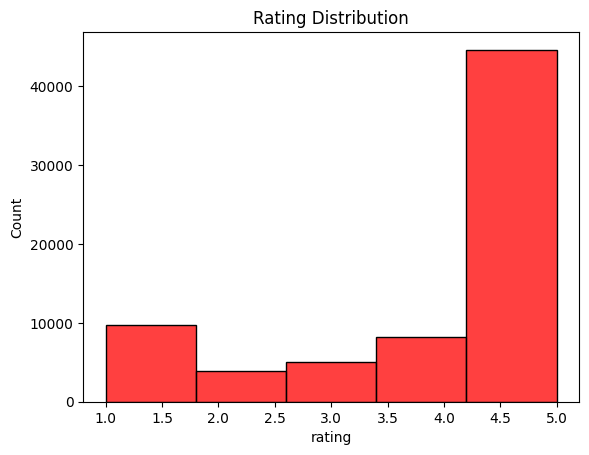

In [14]:
sns.histplot(df_eda['rating'],color='red',bins=5)
plt.title('Rating Distribution')
plt.show()

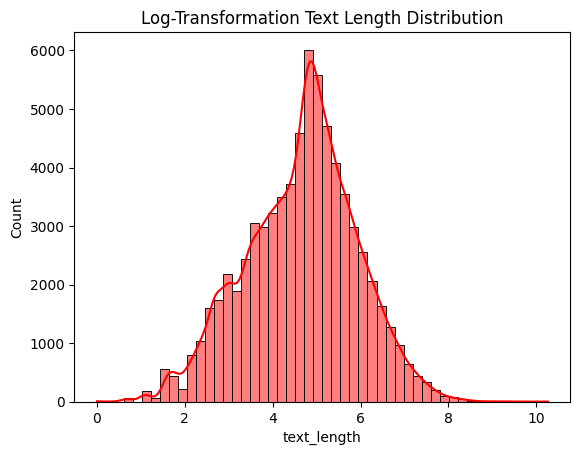

In [15]:
sns.histplot(np.log1p(df_eda['text_length']),kde=True,color='red',bins=50)
plt.title('Log-Transformation Text Length Distribution')
plt.show()

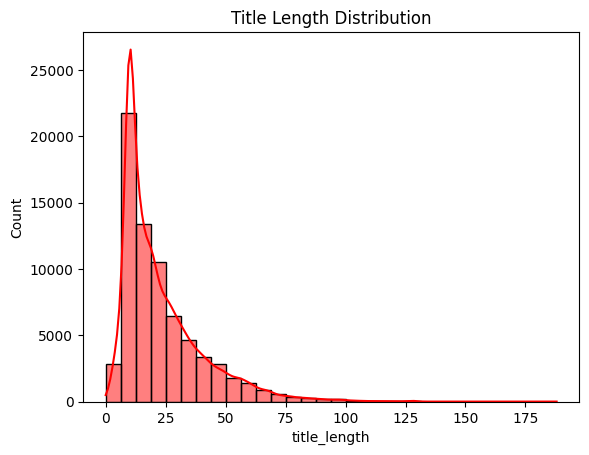

In [16]:
sns.histplot(df_eda['title_length'],kde=True,color='red',bins=30)
plt.title('Title Length Distribution')
plt.show()

# SQL Structured Dump <a class="anchor" id="fourth-bullet"></a>

In [18]:
engine = create_engine('mysql+pymysql://root:*@localhost/amazon_reviews_db')

df_filtered.to_sql('product_reviews', engine, if_exists='replace', index=False)

71483

In [19]:
query = "SELECT * FROM product_reviews"

df_reviews = pd.read_sql(query, engine)

print(df_reviews.head())

df.to_csv('reviews.csv', index=False) 

                        user_id  rating  \
0  AE7Y5RLYIKHOZB5NKKOEKYG2SPSQ       5   
1  AHORTSSMI6ZZFUFWMPT4UFR2ISUQ       4   
2  AFW2PDT3AMT4X3PYQG7FJZH5FXFA       5   
3  AFW2PDT3AMT4X3PYQG7FJZH5FXFA       5   
4  AFUB7CHTXRPD447QVQCHBZVN2IPQ       1   

                                               title  \
0                         Great pictures and recipes   
1                    great for kids who love sports!   
2  A great look at what's new on the kosher scene...   
3  If you enjoy reading an eye-catching, easy-to-...   
4                            Too many “ gear ads” !!   

                                                text  helpful_vote  \
0                Wonderful recipes in this magazine.             0   
1  Great sports magazine that's on my 9 year olds...             1   
2  "Joy of Kosher" magazine fills a much-needed n...             4   
3  I've been addicted to Martha Stewart's Everyda...             4   
4                                      Too many ads!  

# Encoding Text to Sentiment Value <a class="anchor" id="fifth-bullet"></a>

In [20]:
df = pd.read_csv('reviews.csv')

In [21]:
df_text = df['text']
df_text = df['text'].str.slice(0, 512)
df_text.astype(str)
df_text.head(10)

0                  Wonderful recipes in this magazine.
1    Great sports magazine that's on my 9 year olds...
2    "Joy of Kosher" magazine fills a much-needed n...
3    I've been addicted to Martha Stewart's Everyda...
4                                        Too many ads!
5    I was so excited about this magazine but didn'...
6    I've renewed this magazine for my mom and she ...
7    It took two months before she got her first ma...
8    I have been reading digitally for years but de...
9    For many years, I have subscribed to PIECEWORK...
Name: text, dtype: object

In [22]:
df_text = df_text.fillna('No Review')
print(df_text[4717] == 'No Review')

True


In [ ]:
def sentiment_score(positive, negative):
    return positive - negative

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    return_all_scores=True
)

for x in range(len(df_text)):
    if df_text[x] == 'No Review':
       df_text[x] = 0
    else:
        d = distilled_student_sentiment_classifier (df_text[x])
        final_score = sentiment_score(d[0][0]['score'], d[0][2]['score'])
        df_text[x] = final_score

In [24]:
df_title = df['title']
df_title = df['title'].str.slice(0, 512)
df_title.astype(str)
df_title.head(10)

0                           Great pictures and recipes
1                      great for kids who love sports!
2    A great look at what's new on the kosher scene...
3    If you enjoy reading an eye-catching, easy-to-...
4                              Too many “ gear ads” !!
5                                           Not for me
6                                           Loving it!
7                           Giftfor mom. She loves it.
8                         I like the crossword puzzles
9    Short Historical Articles on All Kinds of Hand...
Name: title, dtype: object

In [25]:
df_title = df_title.fillna('No Review')
print(df_title[4717] == 'No Review')

True


In [ ]:
def sentiment_score(positive, negative):
    return positive - negative

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    return_all_scores=True
)

for x in range(len(df_title)):
    if df_title[x] == 'No Review':
       df_title[x] = 0
    else:
        d = distilled_student_sentiment_classifier (df_title[x])
        final_score = sentiment_score(d[0][0]['score'], d[0][2]['score'])
        df_title[x] = final_score
        print(final_score)



In [ ]:
df_text.to_csv('sentiment_text.csv')

In [ ]:
df_title.to_csv('sentiment_title.csv')

In [26]:
df_sentiment_text = pd.read_csv('sentiment_text_copy.csv')
df_sentiment_title = pd.read_csv('sentiment_title_copy.csv')

df_sentiment_text['text_sentiment'] = df_sentiment_text['text']
df_sentiment_title['title_sentiment'] = df_sentiment_title['title']


In [27]:
df_processed = pd.concat([df, df_sentiment_text['text_sentiment'], df_sentiment_title['title_sentiment']], axis=1)
df_processed = df_processed[['user_id', 'rating', 'title', 'text', 'helpful_vote', 'verified_purchase', 'text_sentiment', 'title_sentiment']]
df_processed.head(20)

,user_id,rating,title,text,helpful_vote,verified_purchase,text_sentiment,title_sentiment
0,AE7Y5RLYIKHOZB5NKKOEKYG2SPSQ,5,Great pictures and recipes,Wonderful recipes in this magazine.,0,True,0.782567,0.609048
1,AHORTSSMI6ZZFUFWMPT4UFR2ISUQ,4,great for kids who love sports!,Great sports magazine that's on my 9 year olds...,1,True,0.636980,0.987349
2,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,5,A great look at what's new on the kosher scene...,"""Joy of Kosher"" magazine fills a much-needed n...",4,False,0.597118,0.906017
3,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,5,"If you enjoy reading an eye-catching, easy-to-...",I've been addicted to Martha Stewart's Everyda...,4,False,0.762665,0.804788
4,AFUB7CHTXRPD447QVQCHBZVN2IPQ,1,Too many “ gear ads” !!,Too many ads!,13,True,0.493808,0.186977
5,AFPHKIJFGIU4G4POXRFCEF5RJJHA,2,Not for me,I was so excited about this magazine but didn'...,0,True,0.158089,-0.453036
6,AFPHKIJFGIU4G4POXRFCEF5RJJHA,5,Loving it!,I've renewed this magazine for my mom and she ...,0,True,0.694319,0.888506
7,AGRUKTHXESHTPHHK4GQYQNRFZP3A,5,Giftfor mom. She loves it.,It took two months before she got her first ma...,0,True,0.606491,0.901421
8,AEYVXZF5TQB7IGLLS3HJTDWLSKJQ,5,I like the crossword puzzles,I have been reading digitally for years but de...,0,True,-0.043144,0.130388
9,AEYGPUCRKH7G4VM22FM3VAKSQ23Q,5,Short Historical Articles on All Kinds of Hand...,"For many years, I have subscribed to PIECEWORK...",8,False,0.625879,0.484168


In [28]:
df_processed.to_sql('product_reviews', engine, if_exists='replace', index=False)

71497

# K-Mean Clustering <a class="anchor" id="sixth-bullet"></a>

In [157]:
query = "SELECT rating, verified_purchase, text_sentiment, title_sentiment FROM product_reviews"

df = pd.read_sql(query, engine)

kmeans = KMeans(n_clusters=2)
kmeans.fit(df)

cluster_labels = kmeans.labels_

cluster_descriptions = {0: 'High likelihood of renewal', 1: 'low likelihood of renewal'}

df['cluster'] = cluster_labels

df['cluster_label'] = df['cluster'].map(cluster_descriptions)
df.to_sql('product_reviews_cluster', engine, if_exists='replace', index=False)

71497

In [201]:
df[df['cluster'] == 0].head(20)

,rating,verified_purchase,text_sentiment,title_sentiment,cluster,cluster_label
0,5,1,0.782567,0.609048,0,High likelihood of renewal
1,4,1,0.636980,0.987349,0,High likelihood of renewal
2,5,0,0.597118,0.906017,0,High likelihood of renewal
3,5,0,0.762665,0.804788,0,High likelihood of renewal
6,5,1,0.694319,0.888506,0,High likelihood of renewal
7,5,1,0.606491,0.901421,0,High likelihood of renewal
8,5,1,-0.043144,0.130388,0,High likelihood of renewal
9,5,0,0.625879,0.484168,0,High likelihood of renewal
10,5,0,0.875624,0.837912,0,High likelihood of renewal
11,5,1,0.929266,0.511207,0,High likelihood of renewal


In [202]:
df[df['cluster'] == 1].head(20)

,rating,verified_purchase,text_sentiment,title_sentiment,cluster,cluster_label
4,1,1,0.493808,0.186977,1,low likelihood of renewal
5,2,1,0.158089,-0.453036,1,low likelihood of renewal
16,1,1,-0.177464,-0.344488,1,low likelihood of renewal
17,1,1,-0.220217,-0.344488,1,low likelihood of renewal
18,2,0,0.076966,-0.390277,1,low likelihood of renewal
36,1,1,0.050597,0.413658,1,low likelihood of renewal
39,1,1,-0.233190,-0.117599,1,low likelihood of renewal
45,2,1,-0.362253,0.253033,1,low likelihood of renewal
54,2,0,0.464652,0.265741,1,low likelihood of renewal
56,3,0,0.759276,0.448727,1,low likelihood of renewal


# Post EDA <a class="anchor" id="seventh-bullet"></a>

In [160]:
query = "SELECT * FROM product_reviews"

df_eda2 = pd.read_sql(query, engine)

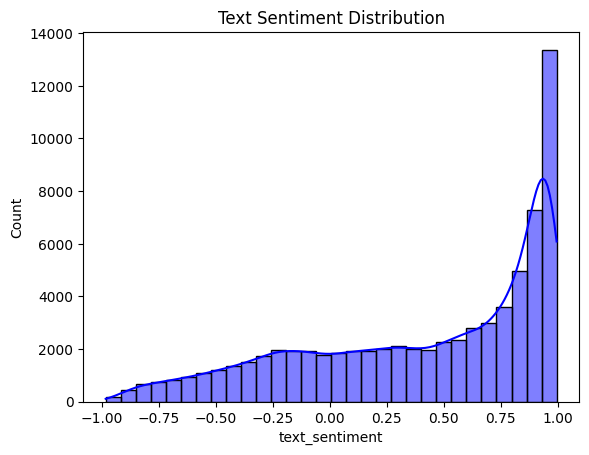

In [161]:
sns.histplot(df_eda2['text_sentiment'],kde=True,color='blue',bins=30)
plt.title('Text Sentiment Distribution')
plt.show()

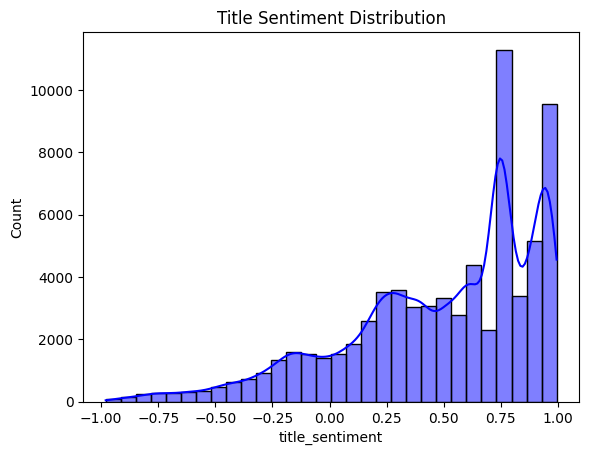

In [162]:
sns.histplot(df_eda2['title_sentiment'],kde=True,color='blue',bins=30)
plt.title('Title Sentiment Distribution')
plt.show()

In [163]:
query = "SELECT * FROM product_reviews_cluster"

df_eda3 = pd.read_sql(query, engine)

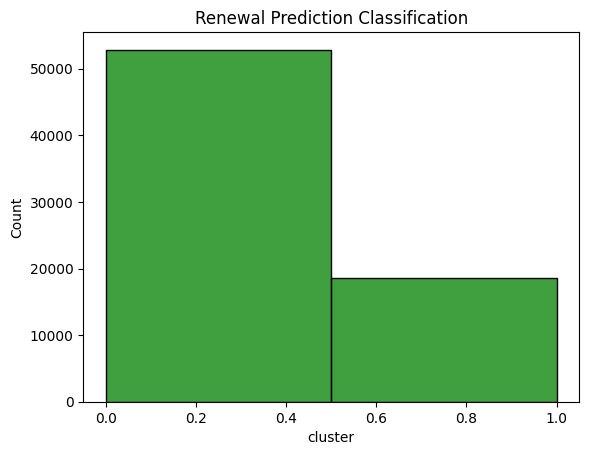

In [164]:
sns.histplot(df_eda3['cluster'],color='green',bins=2)
plt.title('Renewal Prediction Classification')
plt.show()

The graphs in blue represent the distribution of the sentiment values determined by the sentiment analysis model and it shows that for both cases, there is a significant left skew meaning there is significantly more positive reviews compared to negative reviews. This aligns with the results of the K-mean cluster predictions as there is significantly more cases where the chances of renewal are likely.

In [165]:
df_processed2 = pd.concat([df_eda2, df_eda3[['cluster', 'cluster_label']]], axis=1)
df_processed2.to_sql('product_reviews_combined', engine, if_exists='replace', index=False)
df_processed2.head(10)

,user_id,rating,title,text,helpful_vote,verified_purchase,text_sentiment,title_sentiment,cluster,cluster_label
0,AE7Y5RLYIKHOZB5NKKOEKYG2SPSQ,5,Great pictures and recipes,Wonderful recipes in this magazine.,0,1,0.782567,0.609048,0,High likelihood of renewal
1,AHORTSSMI6ZZFUFWMPT4UFR2ISUQ,4,great for kids who love sports!,Great sports magazine that's on my 9 year olds...,1,1,0.636980,0.987349,0,High likelihood of renewal
2,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,5,A great look at what's new on the kosher scene...,"""Joy of Kosher"" magazine fills a much-needed n...",4,0,0.597118,0.906017,0,High likelihood of renewal
3,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,5,"If you enjoy reading an eye-catching, easy-to-...",I've been addicted to Martha Stewart's Everyda...,4,0,0.762665,0.804788,0,High likelihood of renewal
4,AFUB7CHTXRPD447QVQCHBZVN2IPQ,1,Too many “ gear ads” !!,Too many ads!,13,1,0.493808,0.186977,1,low likelihood of renewal
5,AFPHKIJFGIU4G4POXRFCEF5RJJHA,2,Not for me,I was so excited about this magazine but didn'...,0,1,0.158089,-0.453036,1,low likelihood of renewal
6,AFPHKIJFGIU4G4POXRFCEF5RJJHA,5,Loving it!,I've renewed this magazine for my mom and she ...,0,1,0.694319,0.888506,0,High likelihood of renewal
7,AGRUKTHXESHTPHHK4GQYQNRFZP3A,5,Giftfor mom. She loves it.,It took two months before she got her first ma...,0,1,0.606491,0.901421,0,High likelihood of renewal
8,AEYVXZF5TQB7IGLLS3HJTDWLSKJQ,5,I like the crossword puzzles,I have been reading digitally for years but de...,0,1,-0.043144,0.130388,0,High likelihood of renewal
9,AEYGPUCRKH7G4VM22FM3VAKSQ23Q,5,Short Historical Articles on All Kinds of Hand...,"For many years, I have subscribed to PIECEWORK...",8,0,0.625879,0.484168,0,High likelihood of renewal


# Confidence Interval <a class="anchor" id="eighth-bullet"></a>

In [166]:
query = "SELECT * FROM product_reviews_combined"

df_ci = pd.read_sql(query, engine)

predicted_probabilities = df_ci['cluster']

n_iterations = 1000
n_size = len(predicted_probabilities)
bootstrap_means = []

for _ in range(n_iterations):
    sample = np.random.choice(predicted_probabilities, size=n_size, replace=True)
    bootstrap_means.append(np.mean(sample))

ci_lower = np.percentile(bootstrap_means, 2.5)
ci_upper = np.percentile(bootstrap_means, 97.5)

print(f"Confidence Interval: ({ci_lower}, {ci_upper})")

Confidence Interval: (0.2577447305481349, 0.2639275074478649)


# SUPG Approximate Proxy Labeling <a class="anchor" id="ninth-bullet"></a>

### Oracle Labeling and Preprocessing

In [167]:
query = "SELECT * FROM product_reviews_combined"

df_supg = pd.read_sql(query, engine)
df_supg = df_supg[['rating', 'title', 'text', 'verified_purchase', 'text_sentiment', 'title_sentiment', 'cluster']]
df_supg['label'] = 2
df_supg.head(10)

,rating,title,text,verified_purchase,text_sentiment,title_sentiment,cluster,label
0,5,Great pictures and recipes,Wonderful recipes in this magazine.,1,0.782567,0.609048,0,2
1,4,great for kids who love sports!,Great sports magazine that's on my 9 year olds...,1,0.636980,0.987349,0,2
2,5,A great look at what's new on the kosher scene...,"""Joy of Kosher"" magazine fills a much-needed n...",0,0.597118,0.906017,0,2
3,5,"If you enjoy reading an eye-catching, easy-to-...",I've been addicted to Martha Stewart's Everyda...,0,0.762665,0.804788,0,2
4,1,Too many “ gear ads” !!,Too many ads!,1,0.493808,0.186977,1,2
5,2,Not for me,I was so excited about this magazine but didn'...,1,0.158089,-0.453036,1,2
6,5,Loving it!,I've renewed this magazine for my mom and she ...,1,0.694319,0.888506,0,2
7,5,Giftfor mom. She loves it.,It took two months before she got her first ma...,1,0.606491,0.901421,0,2
8,5,I like the crossword puzzles,I have been reading digitally for years but de...,1,-0.043144,0.130388,0,2
9,5,Short Historical Articles on All Kinds of Hand...,"For many years, I have subscribed to PIECEWORK...",0,0.625879,0.484168,0,2


In [168]:
print(df_supg['text'].iloc[46867])

I was looking for a health/fitness magazine that was worried more about health and fitness and less worried about selling me s*** that I don't nessisarrily need. I like the arrivals and the advice. I enjoy the recipes and have tried a few yum. Is there some controversy over 1 magazine cover yes. Should that devalue the entire endeavor nope. If you are looking for style hair makeup try looking at shape or women's health. If you want a simple magazine that you will read with some substance this is it.<br />I will add the only negative for me is the plug for lifetime fitness. Other then that solid read<br /><br />Been reading for 2 years


In [169]:
print(df_supg.iloc[46867])

rating                                                               5
title                                                  A good magazine
text                 I was looking for a health/fitness magazine th...
verified_purchase                                                    1
text_sentiment                                               -0.489579
title_sentiment                                               0.980455
cluster                                                              0
label                                                                2
Name: 46867, dtype: object


In [170]:
df_supg.loc[66870, 'label'] = 0
df_supg.loc[53752, 'label'] = 0
df_supg.loc[30379, 'label'] = 0
df_supg.loc[1007, 'label'] = 1
df_supg.loc[61838, 'label'] = 0
df_supg.loc[29450, 'label'] = 0
df_supg.loc[46308, 'label'] = 0
df_supg.loc[1228, 'label'] = 0
df_supg.loc[24223, 'label'] = 0
df_supg.loc[28769, 'label'] = 1
df_supg.loc[53067, 'label'] = 1
df_supg.loc[9867, 'label'] = 1
df_supg.loc[50260, 'label'] = 1
df_supg.loc[70937, 'label'] = 1
df_supg.loc[62096, 'label'] = 1
df_supg.loc[15932, 'label'] = 0
df_supg.loc[16359, 'label'] = 0
df_supg.loc[59343, 'label'] = 0
df_supg.loc[43920, 'label'] = 0
df_supg.loc[55331, 'label'] = 0
df_supg.loc[26635, 'label'] = 0
df_supg.loc[21954, 'label'] = 0
df_supg.loc[17420, 'label'] = 0
df_supg.loc[28715, 'label'] = 0
df_supg.loc[48823, 'label'] = 1
df_supg.loc[10700, 'label'] = 1
df_supg.loc[13568, 'label'] = 0
df_supg.loc[66214, 'label'] = 1
df_supg.loc[57966, 'label'] = 0
df_supg.loc[2953, 'label'] = 0
df_supg.loc[63212, 'label'] = 0
df_supg.loc[12761, 'label'] = 0
df_supg.loc[35633, 'label'] = 1
df_supg.loc[19413, 'label'] = 1
df_supg.loc[58818, 'label'] = 0
df_supg.loc[62579, 'label'] = 0
df_supg.loc[63674, 'label'] = 0
df_supg.loc[64774, 'label'] = 0
df_supg.loc[8350, 'label'] = 1
df_supg.loc[65663, 'label'] = 0
df_supg.loc[26658, 'label'] = 0
df_supg.loc[41204, 'label'] = 0
df_supg.loc[46471, 'label'] = 0
df_supg.loc[40057, 'label'] = 1
df_supg.loc[60469, 'label'] = 1
df_supg.loc[42892, 'label'] = 0
df_supg.loc[43519, 'label'] = 1
df_supg.loc[38086, 'label'] = 0
df_supg.loc[69637, 'label'] = 0
df_supg.loc[46867, 'label'] = 0

In [171]:
def dataPreprocess(df_supg):
    data = df_supg[['rating', 'verified_purchase', 'text_sentiment', 'title_sentiment', 'label']]
    data = data[data['label'] == 2]
    data = data.drop(columns='label')
    data = data.values
    return data
    
def labelPreprocess(df_supg):
    label = df_supg[['rating', 'verified_purchase', 'text_sentiment', 'title_sentiment', 'label']]
    label = label[(label['label'] == 1) | (label['label'] == 0)]
    label = label.drop(columns='label')
    label = label.values
    return label

In [172]:
data = dataPreprocess(df_supg)
label = labelPreprocess(df_supg)
print(data.shape)
print(label.shape)

(71447, 4)
(50, 4)


### Proxy Labeling

In [178]:
def EuclideanDist(x, y):
    return np.sqrt(sum(x - y) ** 2)

def propogateLabels(data, label, iterations):
    closest_pairs = []
    for _ in range(iterations):
        distances = []
        random_index = np.random.choice(data.shape[0])
        unlabeled = data[random_index]

        for j in range(len(label)):
            distances.append(EuclideanDist(unlabeled, label[j]))

        closest_index = np.argmin(distances)
        closest_pairs.append((random_index, closest_index))
        
    return closest_pairs

#data = dataPreprocess(df_supg)
#label = labelPreprocess(df_supg)
data = dataPreprocess(df_merged)
label = labelPreprocess(df_merged)
iterations = 100
label_array = propogateLabels(data, label, iterations)
label_array[0:10]


[(55260, np.int64(29)),
 (9842, np.int64(36)),
 (6664, np.int64(73)),
 (853, np.int64(128)),
 (1659, np.int64(75)),
 (54821, np.int64(75)),
 (40827, np.int64(80)),
 (21485, np.int64(43)),
 (35619, np.int64(144)),
 (4056, np.int64(9))]

In [179]:
def dataPostprocess(df_supg):
    data2 = df_supg[['rating', 'verified_purchase', 'text_sentiment', 'title_sentiment', 'label']]
    data2 = data2[data2['label'] == 2]
    return data2
    
def labelPostprocess(df_supg):
    label2 = df_supg[['rating', 'verified_purchase', 'text_sentiment', 'title_sentiment', 'label']]
    label2 = label2[(label2['label'] == 1) | (label2['label'] == 0)]
    return label2

#data2 = dataPostprocess(df_supg)
#label2 = labelPostprocess(df_supg)
data2 = dataPostprocess(df_merged)
label2 = labelPostprocess(df_merged)
len(data2)

71347

In [180]:
def proxyLabeling(data2, label2, label_array):
    label_column_index = data2.columns.get_loc('label')
    for x in range(len(label_array)):
        data2.iloc[label_array[x][0], label_column_index] = label2.iloc[label_array[x][1], label_column_index]
    return data2

df_proxy = proxyLabeling(data2, label2, label_array)

In [176]:
columns = ['rating', 'verified_purchase', 'text_sentiment', 'title_sentiment', 'label']
df_merged = pd.DataFrame(columns=columns)

In [181]:
df_merged = pd.concat([df_proxy, label2], axis=0, ignore_index=True)
print(len(df_merged[(df_merged['label'] == 1) | (df_merged['label'] == 0)]))
df_merged.head(10)

250


,rating,verified_purchase,text_sentiment,title_sentiment,label
0,5,1,0.782567,0.609048,2
1,4,1,0.636980,0.987349,2
2,5,0,0.597118,0.906017,2
3,5,0,0.762665,0.804788,2
4,1,1,0.493808,0.186977,2
5,2,1,0.158089,-0.453036,2
6,5,1,0.694319,0.888506,2
7,5,1,0.606491,0.901421,2
8,5,1,-0.043144,0.130388,2
9,5,0,0.625879,0.484168,2


### Manual Testing

In [186]:
df_merged[(df_merged['label'] == 1) | (df_merged['label'] == 0)].sample(10)

,rating,verified_purchase,text_sentiment,title_sentiment,label
71416,5,1,0.745774,0.599483,0
16185,5,1,0.862514,0.764218,0
54821,5,1,0.954270,0.267412,0
71359,5,0,0.774634,0.718142,0
6726,5,1,0.947280,0.536262,0
71374,5,1,0.211027,0.845975,0
64070,1,0,-0.041259,-0.156311,1
71459,5,1,0.779054,0.914846,0
71489,4,0,-0.236223,0.814761,0
1659,5,1,0.203844,0.980572,0


In [183]:
print(df_supg['text'].iloc[71421])

My money was taken right away- however it has been over a month and I still haven't recieved a single magazine!


In [184]:
print(df_supg.iloc[71421])

rating                                                               1
title                           Over a month later, still no magazine!
text                 My money was taken right away- however it has ...
verified_purchase                                                    1
text_sentiment                                               -0.247478
title_sentiment                                              -0.294567
cluster                                                              1
label                                                                2
Name: 71421, dtype: object


# Logistic Model Testing <a class="anchor" id="twelveth-bullet"></a>

In [187]:
df_supg_labeled = df_merged[(df_merged['label'] == 1) | (df_merged['label'] == 0)]
df_supg_unlabeled = df_merged[df_merged['label'] == 2]

df_supg_labeled['label'] = df_supg_labeled['label'].astype(int)

X_labeled = df_supg_labeled.drop('label', axis=1)
y_labeled = df_supg_labeled['label']

X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on labeled test data: {accuracy}")

Accuracy on labeled test data: 0.94


/var/folders/dd/_ztt_jls2k3c4svmnfr9gm0c0000gn/T/ipykernel_73703/2727534179.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_supg_labeled['label'] = df_supg_labeled['label'].astype(int)


In [188]:
X_unlabeled = df_supg_unlabeled.drop('label', axis=1) 
y_unlabeled_pred = model.predict(X_unlabeled)

df_supg_unlabeled['predicted_label'] = y_unlabeled_pred

df_supg_labeled['predicted_label'] = df_supg_labeled['label']
df_log = pd.concat([df_supg_unlabeled, df_supg_labeled], axis=0, ignore_index=True)
df_log.head(10)

/var/folders/dd/_ztt_jls2k3c4svmnfr9gm0c0000gn/T/ipykernel_73703/2401289833.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_supg_unlabeled['predicted_label'] = y_unlabeled_pred
/var/folders/dd/_ztt_jls2k3c4svmnfr9gm0c0000gn/T/ipykernel_73703/2401289833.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_supg_labeled['predicted_label'] = df_supg_labeled['label']


,rating,verified_purchase,text_sentiment,title_sentiment,label,predicted_label
0,5,1,0.782567,0.609048,2,0
1,4,1,0.636980,0.987349,2,0
2,5,0,0.597118,0.906017,2,0
3,5,0,0.762665,0.804788,2,0
4,1,1,0.493808,0.186977,2,1
5,2,1,0.158089,-0.453036,2,1
6,5,1,0.694319,0.888506,2,0
7,5,1,0.606491,0.901421,2,0
8,5,1,-0.043144,0.130388,2,0
9,5,0,0.625879,0.484168,2,0


### Logistic Model EDA

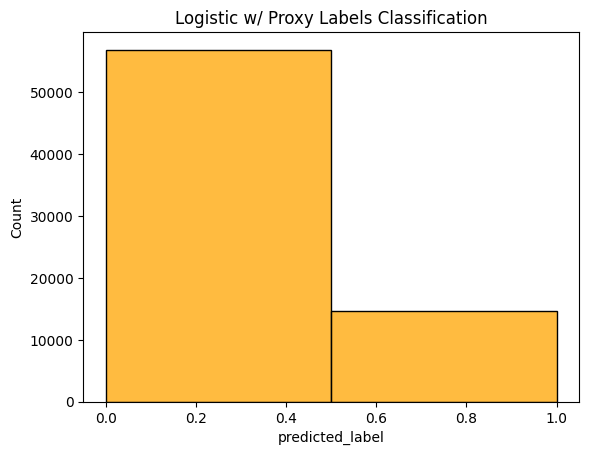

In [189]:
sns.histplot(df_log['predicted_label'],color='orange',bins=2)
plt.title('Logistic w/ Proxy Labels Classification')
plt.show()

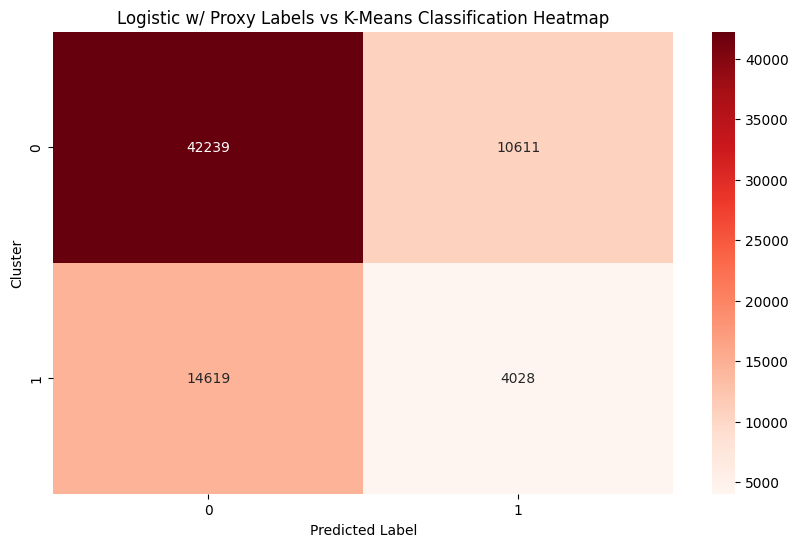

In [190]:
df_eda4 = pd.DataFrame({
    'predicted_label': df_log['predicted_label'],
    'cluster': df_eda3['cluster'] 
})

heatmap_data = pd.crosstab(df_eda4['cluster'], df_eda4['predicted_label'])

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Reds', fmt='d')
plt.title('Logistic w/ Proxy Labels vs K-Means Classification Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('Cluster')
plt.show()

# Proof of Convergence <a class="anchor" id="tenth-bullet"></a>

This section is a proof of convergence that the proxy labeling is a reliable source of approximately labeling large sums of unlabeled data given a small sample of human-labeled data. This proof will document the accuracy of the labels until it reaches a point where the label propagation stops making changes to the dataset. In other words, once the algorithm runs for enough iterations, the labeled data should be stable, and no new labels should be assigned.

In [192]:
query = "SELECT * FROM product_reviews_combined"

df_supg = pd.read_sql(query, engine)
df_supg = df_supg[['rating', 'title', 'text', 'verified_purchase', 'text_sentiment', 'title_sentiment', 'cluster']]
df_supg['label'] = 2
df_supg.head(10)

,rating,title,text,verified_purchase,text_sentiment,title_sentiment,cluster,label
0,5,Great pictures and recipes,Wonderful recipes in this magazine.,1,0.782567,0.609048,0,2
1,4,great for kids who love sports!,Great sports magazine that's on my 9 year olds...,1,0.636980,0.987349,0,2
2,5,A great look at what's new on the kosher scene...,"""Joy of Kosher"" magazine fills a much-needed n...",0,0.597118,0.906017,0,2
3,5,"If you enjoy reading an eye-catching, easy-to-...",I've been addicted to Martha Stewart's Everyda...,0,0.762665,0.804788,0,2
4,1,Too many “ gear ads” !!,Too many ads!,1,0.493808,0.186977,1,2
5,2,Not for me,I was so excited about this magazine but didn'...,1,0.158089,-0.453036,1,2
6,5,Loving it!,I've renewed this magazine for my mom and she ...,1,0.694319,0.888506,0,2
7,5,Giftfor mom. She loves it.,It took two months before she got her first ma...,1,0.606491,0.901421,0,2
8,5,I like the crossword puzzles,I have been reading digitally for years but de...,1,-0.043144,0.130388,0,2
9,5,Short Historical Articles on All Kinds of Hand...,"For many years, I have subscribed to PIECEWORK...",0,0.625879,0.484168,0,2


In [193]:
df_supg.loc[66870, 'label'] = 0
df_supg.loc[53752, 'label'] = 0
df_supg.loc[30379, 'label'] = 0
df_supg.loc[1007, 'label'] = 1
df_supg.loc[61838, 'label'] = 0
df_supg.loc[29450, 'label'] = 0
df_supg.loc[46308, 'label'] = 0
df_supg.loc[1228, 'label'] = 0
df_supg.loc[24223, 'label'] = 0
df_supg.loc[28769, 'label'] = 1
df_supg.loc[53067, 'label'] = 1
df_supg.loc[9867, 'label'] = 1
df_supg.loc[50260, 'label'] = 1
df_supg.loc[70937, 'label'] = 1
df_supg.loc[62096, 'label'] = 1
df_supg.loc[15932, 'label'] = 0
df_supg.loc[16359, 'label'] = 0
df_supg.loc[59343, 'label'] = 0
df_supg.loc[43920, 'label'] = 0
df_supg.loc[55331, 'label'] = 0
df_supg.loc[26635, 'label'] = 0
df_supg.loc[21954, 'label'] = 0
df_supg.loc[17420, 'label'] = 0
df_supg.loc[28715, 'label'] = 0
df_supg.loc[48823, 'label'] = 1
df_supg.loc[10700, 'label'] = 1
df_supg.loc[13568, 'label'] = 0
df_supg.loc[66214, 'label'] = 1
df_supg.loc[57966, 'label'] = 0
df_supg.loc[2953, 'label'] = 0
df_supg.loc[63212, 'label'] = 0
df_supg.loc[12761, 'label'] = 0
df_supg.loc[35633, 'label'] = 1
df_supg.loc[19413, 'label'] = 1
df_supg.loc[58818, 'label'] = 0
df_supg.loc[62579, 'label'] = 0
df_supg.loc[63674, 'label'] = 0
df_supg.loc[64774, 'label'] = 0
df_supg.loc[8350, 'label'] = 1
df_supg.loc[65663, 'label'] = 0
df_supg.loc[26658, 'label'] = 0
df_supg.loc[41204, 'label'] = 0
df_supg.loc[46471, 'label'] = 0
df_supg.loc[40057, 'label'] = 1
df_supg.loc[60469, 'label'] = 1
df_supg.loc[42892, 'label'] = 0
df_supg.loc[43519, 'label'] = 1
df_supg.loc[38086, 'label'] = 0
df_supg.loc[69637, 'label'] = 0
df_supg.loc[46867, 'label'] = 0

In [196]:

#Formula used to calculate the distance of between the label and randomly selected vectors
def EuclideanDist(x, y):
    return np.sqrt(sum((x - y) ** 2))

#Calculates the distance between the randomly selected vectors and the distance of all labeled vectors and returns the closest matching index
def propogateLabels(data, label, num_changes=100):
    closest_pairs = []
    updated_label_set = label.copy()
    
    #Iterates 100 randomly selected vectors
    for _ in range(num_changes):
        distances = []
        random_index = np.random.choice(data.shape[0])
        unlabeled = data[random_index]
        
        #Calculates the distance between the 100 vectors and the labels
        for j in range(len(updated_label_set)):
            distances.append(EuclideanDist(unlabeled, updated_label_set[j]))
        
        #Returns the closest match and updates the label to include the new ones
        closest_index = np.argmin(distances)
        closest_pairs.append((random_index, closest_index))

        new_labeled_point = data[random_index].reshape(1, -1)
        updated_label_set = np.vstack([updated_label_set, new_labeled_point])  

    return closest_pairs, updated_label_set

#Processes the original dataframe
def dataPreprocess(df_supg):
    data = df_supg[['rating', 'verified_purchase', 'text_sentiment', 'title_sentiment', 'label']]
    data = data[data['label'] == 2].drop(columns='label')
    return data.values

def labelPreprocess(df_supg):
    label = df_supg[['rating', 'verified_purchase', 'text_sentiment', 'title_sentiment', 'label']]
    label = label[(label['label'] == 1) | (label['label'] == 0)]
    return label.drop(columns='label').values

#Takes the array containing pairs of the 100 vectors index and the index of which label it was similar to
def proxyLabeling(data2, label2, label_array):
    #Counts the number of times the labels switch to depict whether the initial decisions made by the proxy is accurate
    switch_count = 0  
    for data_index, label_index in label_array:
        if data_index < len(data2) and label_index < len(label2):
            old_label = data2.iloc[data_index, data2.columns.get_loc('label')]
            new_label = label2.iloc[label_index, label2.columns.get_loc('label')]
            
            if old_label != new_label:
                switch_count += 1
            #Updates the labels
            data2.iloc[data_index, data2.columns.get_loc('label')] = new_label  
    
    return data2, switch_count

data_test = dataPreprocess(df_supg)
label_test = labelPreprocess(df_supg)
data2_test = df_supg[df_supg['label'] == 2]
label2_test = df_supg[df_supg['label'].isin([0, 1])]

target_label_count = 20000
iteration = 0
switch_tracker = []
df_merged_test = pd.DataFrame(columns=['rating', 'verified_purchase', 'text_sentiment', 'title_sentiment', 'label'])

#Iterates the proxy labeling until 20000 rows are labeled
#Purposely included non-replacement in the randomly selected vectors to demonstrate if the algorithm changes its previous decision or not
while len(df_merged_test[(df_merged_test['label'] == 1) | (df_merged_test['label'] == 0)]) < target_label_count:
    label_array_test, label_test = propogateLabels(data_test, label_test, num_changes=100)
    df_proxy_test, switch_count = proxyLabeling(data2_test, label2_test, label_array_test)
    
    df_merged_test = pd.concat([df_merged_test, df_proxy_test], axis=0, ignore_index=True)
    switch_tracker.append({'iteration': iteration, 'switch_count': switch_count})
    
    print(f"Iteration {iteration}: Labeled Points: {len(df_merged_test[(df_merged_test['label'] == 1) | (df_merged_test['label'] == 0)])}, Switches: {switch_count}")
    iteration += 1

print(switch_tracker)


/var/folders/dd/_ztt_jls2k3c4svmnfr9gm0c0000gn/T/ipykernel_73703/1995534950.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_merged_test = pd.concat([df_merged_test, df_proxy_test], axis=0, ignore_index=True)


Iteration 0: Labeled Points: 56, Switches: 56
Iteration 1: Labeled Points: 148, Switches: 36
Iteration 2: Labeled Points: 254, Switches: 14
Iteration 3: Labeled Points: 372, Switches: 12
Iteration 4: Labeled Points: 507, Switches: 17
Iteration 5: Labeled Points: 650, Switches: 8
Iteration 6: Labeled Points: 795, Switches: 2
Iteration 7: Labeled Points: 945, Switches: 5
Iteration 8: Labeled Points: 1098, Switches: 3
Iteration 9: Labeled Points: 1258, Switches: 7
Iteration 10: Labeled Points: 1420, Switches: 2
Iteration 11: Labeled Points: 1593, Switches: 11
Iteration 12: Labeled Points: 1770, Switches: 4
Iteration 13: Labeled Points: 1951, Switches: 4
Iteration 14: Labeled Points: 2137, Switches: 5
Iteration 15: Labeled Points: 2325, Switches: 2
Iteration 16: Labeled Points: 2515, Switches: 2
Iteration 17: Labeled Points: 2709, Switches: 4
Iteration 18: Labeled Points: 2905, Switches: 2
Iteration 19: Labeled Points: 3104, Switches: 3
Iteration 20: Labeled Points: 3305, Switches: 2
Itera

In [5]:
df_eda5 = pd.DataFrame(switch_tracker)
print(df_eda5)

NameError: name 'switch_tracker' is not defined

In [4]:
sns.lineplot(x="iteration", y="switch_count", data=df_eda5, linestyle="o", color="blue")

plt.xlabel("Iteration")
plt.ylabel("Switch Count")
plt.title("Switch Count Over Iterations")
plt.grid(True)

NameError: name 'df_eda5' is not defined

# Summary <a class="anchor" id="eleventh-bullet"></a>

In this project, K-Mean Clustering was used as a method of grouping he data into positive/renewed subscription or negative/not renewed subscription because the data was unstructured and has no labels.

One key decision involved removing the "helpful vote" column from the dataset. Initially, this column appeared to provide additional insights into the quality or impact of a review, but during the clustering process, it was found to introduce confusion. The helpful vote count is often subjective, as it doesn't necessarily correlate with the sentiment expressed in the review itself. Some reviews had a high number of helpful votes because it helped inform others of bad subscription policies, and other negative factors.

Another critical design decision was converting the raw text of the reviews and titles into sentiment values using a pretrained sentimental analysis model. Since K-Means and other machine learning models work with numerical data, the reviews were subjected to sentiment analysis to quantify their emotional tone. This transformation involved converting text into numeric sentiment scores—positive, negative, or neutral—that could then be processed by the clustering algorithm.

To enhance the reliability of the model, 50 data points were manually labeled at random. This small, randomly selected sample was crucial for expanding the labeled data using proxy labeling. By manually assigning labels to a subset of the data, the model's output could be compared to human judgment. For future improvement, I would increase the number of hand-labeled dataset.

I also used the Euclidean distance formula for proxy labeling significantly improved the computational efficiency of the clustering process. This is a very commonly used formula for calculating the distance between two vectors.

There were many instances where bias may have been introduced. Beginning at the dataset, in the pre exploratory data analysis, it showed there was an overwhelming majority of positive reviews, which was likely caused since more people would want to leave a review if their experience was positive. While there is a skew to the ratings, it was useful for validating the K-Mean Cluster classification and the Logistic model with approximate labeling.

These design decisions were made with the aim of maximizing the predictive power and interpretability of the clustering model. By carefully selecting features, refining the clustering process, and introducing proxy labeling, the project successfully uncovered distinct customer segments with varying renewal propensities, enabling targeted marketing and more informed decision-making. Each step was driven by the need for a balance between computational efficiency and predictive accuracy, ensuring that the model could scale and provide valuable insights without becoming overly complex.